In [8]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.append("../code/")
from path_handler import PathHandler
paths=PathHandler()
import perform_bayes_fit as PBF
import one_gauss_bayes as OGB
import fit_one_spectrum as FOS #type: ignore

In [2]:
def extract_raw(fitfile,spectra_csv,wave_nb,wv_num_min,wv_num_max):
    wavenumber, spectra_filter=FOS.filter_by_wavenumber(wave_nb,wv_num_min,wv_num_max)
    nsclks = len(fitfile['sclks'])
    raw_ = np.zeros((nsclks, len(wavenumber)))
    for ii in range(nsclks):
        row_index=np.where(spectra_csv['sclk_string']== fitfile['sclks'][:][ii].decode("utf-8"))[0][0]
        my_spectrum=spectra_csv.iloc[row_index][spectra_filter].to_numpy()
        raw_[ii]=np.array(my_spectrum,dtype=float)
    return raw_
    
    
def extract_fits(myfile):
    wavenumber          =   myfile["wavenumber"][:]
    mindexes            =   myfile["mindexes"][:]
    facet_mean_spectra  =   myfile['facet_mean_spectra'][:]
    facet_mean_continuum=   myfile['facet_mean_continuum'][:]
    band_depth          =   myfile['band_depth'][:] 
    return wavenumber, mindexes, facet_mean_spectra, facet_mean_continuum, band_depth


In [52]:
def properties(
    depth_lims=(0.01,0.035),
    ylims=(0.95,1.01),
    axis0={"xlabel":"Wavenumber (cm$^{-1}$)","ylabel":"Reflectance"},
    axis1={"xlabel":"Band depth"},
    linespecs={"color":"black","linewidth":1,"alpha":0.01,"zorder":0},
    depthspecs={"color":"red","linewidth":1,"alpha":0.01,"zorder":0},
    scatterspecs={"facecolor":"white","s":3,"edgecolor":"black","alpha":0.5},
    meanlinespecs={"color":"blue","linewidth":1,"alpha":1},
):
    axis0['ylim']=ylims
    axis1['xlim']=depth_lims
    axis1['yticks']=[]
    return  axis0, axis1, linespecs, depthspecs, scatterspecs, meanlinespecs


In [60]:

def do_plotting(wavenumber,raw_,facet_mean_spectra,facet_mean_continuum,mindexes,band_depth,depth_lims,ylims):
    
    numfits = 1000
    nbins = int(np.ceil(np.sqrt(numfits)))
    
    axis0, axis1, linespecs, depthspecs, scatterspecs, meanlinespecs = properties(depth_lims,ylims)
    axis0['xlim'] = [wavenumber[0],wavenumber[-1]]
    mean_raw=np.mean(raw_,axis=0)
    fig,axis=plt.subplots(1,2,figsize=(10,4))
    for i in range(facet_mean_spectra.shape[0]):
        xbands=[wavenumber[mindexes[i]],wavenumber[mindexes[i]]]
        ybands=[facet_mean_spectra[i][mindexes[i]],facet_mean_continuum[i][mindexes[i]]]
        axis[0].plot(wavenumber,facet_mean_spectra[i],**linespecs)
        axis[0].plot(wavenumber,facet_mean_continuum[i],**linespecs)
        axis[0].plot(xbands,ybands,**depthspecs)
    
    for ii in range(raw_.shape[0]):
        axis[0].scatter(wavenumber,raw_[ii],**scatterspecs)
    meanlinespecs['color'] = "black"
    meanlinespecs['linewidth'] = 1.5
    axis[0].plot(wavenumber,mean_raw,**meanlinespecs)
    meanlinespecs['color'] = "white"
    meanlinespecs['linewidth'] = 0.75
    axis[0].plot(wavenumber,mean_raw,**meanlinespecs)
    axis[1].hist(band_depth,bins=nbins,color="r",alpha=0.5);
    axis0['ylim']=ylims
    axis[0].set(**axis0)
    axis[1].set(**axis1)
    return fig, axis

In [61]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',  # or 'serif', 'monospace', etc.
    'font.sans-serif': ['Bitstream Vera Serif']  # Replace with your desired font
})

In [138]:
survey_name="EQ2"
model_name="one_gauss"
facet_number="F1420"

In [139]:
depth_lims  =   (0.01,0.035)
ylimits     =   (0.95,1.01)

In [140]:
path_to_spectra=paths.otes_csv(survey_name)
path_to_wave_numbers=paths.wavenumbers
spectra_csv, wave_nb=FOS.open_data(path_to_spectra,path_to_wave_numbers)
wv_num_min, wv_num_max, _,_,_=FOS.set_parameters()

In [141]:
fitfile=h5py.File(paths.facet_spectra(survey_name,model_name,facet_number),'r')
#### Get the fits
wavenumber, mindexes, facet_mean_spectra, facet_mean_continuum, band_depth=extract_fits(fitfile)
#### get the raw spectra
raw_=extract_raw(fitfile,spectra_csv,wave_nb,wv_num_min,wv_num_max)
nspec=raw_.shape[0]

In [142]:
figname = "facet_spectrum_{:s}_{:s}_{:s}.png".format(survey_name,model_name,facet_number)

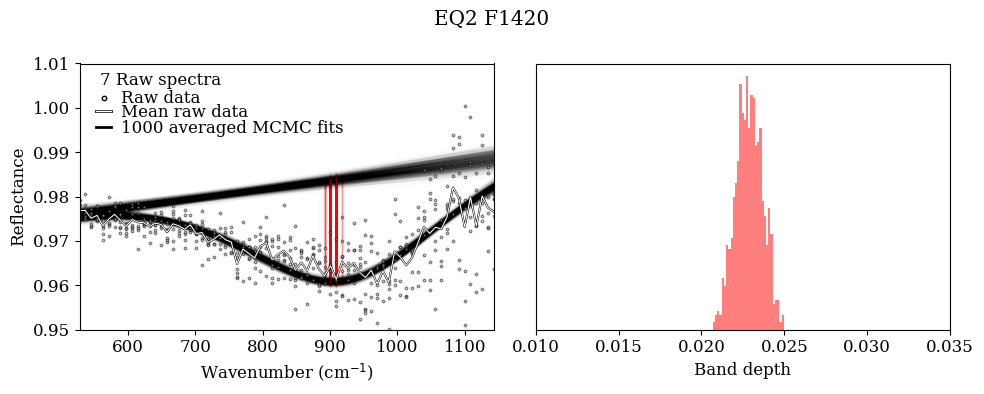

In [143]:
fig, axes=do_plotting(wavenumber,raw_,facet_mean_spectra,facet_mean_continuum,mindexes,band_depth,depth_lims,ylimits)
fig.suptitle("{:s} {:s}".format(survey_name,facet_number))
axes[0].text(0.05,0.92,"{:d} Raw spectra".format(nspec),transform=axes[0].transAxes)
axes[0].scatter([0.06],[0.87],transform=axes[0].transAxes,facecolor="white",edgecolor="black",s=10,alpha=1)
axes[0].text(0.1,0.85,"Raw data",transform=axes[0].transAxes)
axes[0].plot([0.04,0.075],[0.82,0.82],transform=axes[0].transAxes,color="black",linewidth=2)
axes[0].plot([0.04,0.075],[0.82,0.82],transform=axes[0].transAxes,color="white",linewidth=1)
axes[0].text(0.1,0.8,"Mean raw data",transform=axes[0].transAxes)
axes[0].plot([0.04,0.075],[0.76,0.76],transform=axes[0].transAxes,color="black",linewidth=2)
axes[0].text(0.1,0.74,"1000 averaged MCMC fits",transform=axes[0].transAxes)
fig.tight_layout()
fig.savefig(figname)